# Truncation

When the prior is very wide and simulation expense is high, it makes sense to focus our simulations on a certain observation $b_o$. We are effectively estimating the likelihood-to-evidence ratio on a small region around the $\theta_o$ which produced $x_o$. We do this marginally, therefore we take the product of marginal estimates and let that be our truncated region on which to estimate the likelihood-to-evidence ratio. This notebook demonstrates that technique.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# DON'T FORGET TO ACTIVATE THE GPU when on google colab (Edit > Notebook settings)
from os import environ
GOOGLE_COLAB = True if "COLAB_GPU" in environ else False
if GOOGLE_COLAB:
    !pip install git+https://github.com/undark-lab/swyft.git

In [3]:
import numpy as np
import pylab as plt
import torch

import swyft

In [4]:
device = 'cuda' if swyft.utils.is_cuda_available() else "cpu"
n_training_samples = 3000
n_parameters = 2
marginal_indices_1d, marginal_indices_2d = swyft.utils.get_corner_marginal_indices(n_parameters)
observation_key = "x"

n_posterior_samples_for_truncation = 10_000
n_weighted_samples = 10_000

In [5]:
def model(v, sigma = 0.01):
    x = v + np.random.randn(n_parameters)*sigma
    return {observation_key: x}

v_o = np.zeros(n_parameters)
observation_o = model(v_o, sigma = 0.)

n_observation_features = observation_o[observation_key].shape[0]
observation_shapes = {key: value.shape for key, value in observation_o.items()}

In [6]:
simulator = swyft.Simulator(
    model, 
    n_parameters, 
    sim_shapes=observation_shapes,
)

low = -1 * np.ones(n_parameters)
high = 1 * np.ones(n_parameters)
prior = swyft.get_uniform_prior(low, high)

store = swyft.Store.memory_store(simulator)
# drawing samples from the store is Poisson distributed. Simulating slightly more than we need avoids attempting to draw more than we have.
store.add(n_training_samples + 0.01 * n_training_samples, prior)
store.simulate()

Creating new store.
Store: Adding 3039 new samples to simulator store.


## creating a `do_round` function

We call the process of training the marginal likelihood-to-evidence ratio estimator and estimating the support of the truncated prior a `round`. The output of a round is a `bound` object which is then used in the next `round`. It makes sense to encapsulate your round in a function which can be called repeatedly.

We will start by truncating in one dimension (with hyperrectangles as bounds)

In [7]:
def do_round_1d(bound, observation_focus):
    store.add(n_training_samples + 0.01 * n_training_samples, prior, bound=bound)
    store.simulate()
    
    dataset = swyft.Dataset(n_training_samples, prior, store, bound = bound)
    
    network_1d = swyft.get_marginal_classifier(
        observation_key=observation_key,
        marginal_indices=marginal_indices_1d,
        observation_shapes=observation_shapes,
        n_parameters=n_parameters,
        hidden_features=32,
        num_blocks=2,
    )
    mre_1d = swyft.MarginalRatioEstimator(
        marginal_indices=marginal_indices_1d,
        network=network_1d,
        device=device,
    )
    mre_1d.train(dataset)
    posterior_1d = swyft.MarginalPosterior(mre_1d, prior, bound)
    new_bound = posterior_1d.truncate(n_posterior_samples_for_truncation, observation_focus)
    return posterior_1d, new_bound

## Truncating and estimating the marginal posterior over the truncated region

First we train the one-dimensional likelihood-to-evidence ratios, then we train the two-dimensional estimator on the truncated region. This region is defined by the `bound` object.

In [8]:
bound = None
for i in range(3):
    posterior_1d, bound = do_round_1d(bound, observation_o)

training: lr=5e-05, epoch=25, validation loss=0.26931
Store: Adding 1541 new samples to simulator store.
training: lr=5e-05, epoch=25, validation loss=0.41697
Store: Adding 1847 new samples to simulator store.
training: lr=5e-05, epoch=25, validation loss=0.48432


In [9]:
network_2d = swyft.get_marginal_classifier(
    observation_key=observation_key,
    marginal_indices=marginal_indices_2d,
    observation_shapes=observation_shapes,
    n_parameters=n_parameters,
    hidden_features=32,
    num_blocks=2,
)
mre_2d = swyft.MarginalRatioEstimator(
    marginal_indices=marginal_indices_2d,
    network=network_2d,
    device=device,
)

In [10]:
store.add(n_training_samples + 0.01 * n_training_samples, prior, bound=bound)
store.simulate()
dataset = swyft.Dataset(n_training_samples, prior, store, bound = bound)

Store: Adding 498 new samples to simulator store.


In [11]:
mre_2d.train(dataset)

training: lr=5e-05, epoch=25, validation loss=0.060988


In [12]:
weighted_samples_1d = posterior_1d.weighted_sample(n_weighted_samples, observation_o)

posterior_2d = swyft.MarginalPosterior(mre_2d, prior, bound)
weighted_samples_2d = posterior_2d.weighted_sample(n_weighted_samples, observation_o)

1it [00:04,  4.23s/it]


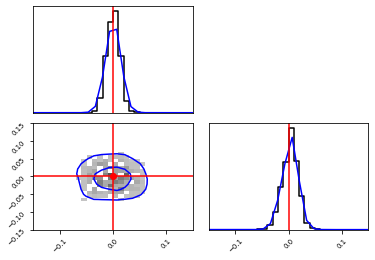

In [13]:
_, _ = swyft.plot.corner(
    weighted_samples_1d, 
    weighted_samples_2d,
    kde=True,
    truth=v_o,
    xlim=[-0.15, 0.15],
    ylim_lower=[-0.15, 0.15],
    bins=200,
)

## Repeat but truncate in two dimensions

First we train the two-dimensional likelihood-to-evidence ratio. We use that bound to estimate the one-dimensional likelihood-to-evidence ratios.

In [14]:
def do_round_2d(bound, observation_focus):
    store.add(n_training_samples + 0.03 * n_training_samples, prior, bound=bound)
    store.simulate()
    
    dataset = swyft.Dataset(n_training_samples, prior, store, bound = bound)
    
    network_2d = swyft.get_marginal_classifier(
        observation_key=observation_key,
        marginal_indices=marginal_indices_2d,
        observation_shapes=observation_shapes,
        n_parameters=n_parameters,
        hidden_features=32,
        num_blocks=2,
    )
    mre_2d = swyft.MarginalRatioEstimator(
        marginal_indices=marginal_indices_2d,
        network=network_2d,
        device=device,
    )
    mre_2d.train(dataset)
    
    posterior_2d = swyft.MarginalPosterior(mre_2d, prior, bound)
    new_bound = posterior_1d.truncate(n_posterior_samples_for_truncation, observation_focus)
    
    return posterior_2d, new_bound

In [15]:
bound = None
for i in range(3):
    posterior_2d, bound = do_round_2d(bound, observation_o)

Store: Adding 25 new samples to simulator store.
training: lr=5e-05, epoch=25, validation loss=0.046777
Store: Adding 56 new samples to simulator store.
training: lr=5e-05, epoch=25, validation loss=0.005059
Store: Adding 22 new samples to simulator store.
training: lr=0.0005, epoch=25, validation loss=0.04868


In [16]:
network_1d = swyft.get_marginal_classifier(
    observation_key=observation_key,
    marginal_indices=marginal_indices_1d,
    observation_shapes=observation_shapes,
    n_parameters=n_parameters,
    hidden_features=32,
    num_blocks=2,
)
mre_1d = swyft.MarginalRatioEstimator(
    marginal_indices=marginal_indices_1d,
    network=network_1d,
    device=device,
)
mre_1d.train(dataset)

training: lr=5e-05, epoch=25, validation loss=0.57287


In [17]:
store.add(n_training_samples + 0.01 * n_training_samples, prior, bound=bound)
store.simulate()
dataset = swyft.Dataset(n_training_samples, prior, store, bound = bound)

Store: Adding 2 new samples to simulator store.


In [18]:
mre_1d.train(dataset)

training: lr=5e-06, epoch=25, validation loss=0.5372


In [19]:
posterior_1d = swyft.MarginalPosterior(mre_1d, prior, bound)
weighted_samples_1d = posterior_1d.weighted_sample(n_weighted_samples, observation_o)

weighted_samples_2d = posterior_2d.weighted_sample(n_weighted_samples, observation_o)

1it [00:04,  4.20s/it]


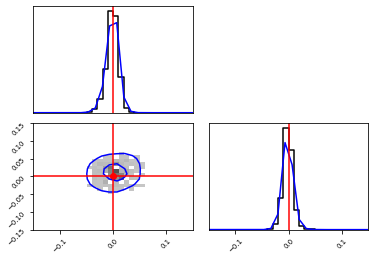

In [20]:
_, _ = swyft.plot.corner(
    weighted_samples_1d, 
    weighted_samples_2d,
    kde=True,
    truth=v_o,
    xlim=[-0.15, 0.15],
    ylim_lower=[-0.15, 0.15],
    bins=200,
)